# Case study
We apply the algorithm developed for the synthetic study to the real dataset, since we obtained good and stable results for the simulated one.

In [1]:
import numpy as np
seed = 12345

import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf

import nest_asyncio
nest_asyncio.apply()
import stan

In [2]:
# set colors 
col_red = '#E21B1B'   #red
col_blue = '#1769E6'  #blue
col_green = '#00D10A' #green
col_grey = '#C8CED0'  #gray

In [3]:
# observed data
df = pd.read_table('data/d18O_record.txt', delimiter = ',')
n = len(df)
df

,t,y_obs
0,1250,0.555756
1,1350,0.182915
2,1450,0.621435
3,1550,-0.234277
4,1650,0.063460
...,...,...
1424,143650,0.157704
1425,143750,-0.139414
1426,143850,-0.338518
1427,143950,-0.480283


In [4]:
# cycles by means of the Bretthorst method
N_cycle = 29
df_cycle = pd.read_table('data/d18O_cycles.txt', delimiter = ',')

df_cycle

,period,A,sigma_A,ph,sigma_ph
0,4321.4,0.1782,0.0086,1.97,0.04
1,5972.6,0.1719,0.0098,0.69,0.11
2,6308.0,0.1509,0.0119,3.05,0.12
3,4792.5,0.1478,0.0077,4.77,0.10
4,5587.2,0.1288,0.0145,0.24,0.17
5,3039.6,0.1251,0.0070,1.94,0.10
6,7180.2,0.1182,0.0095,3.56,0.15
7,3892.1,0.1119,0.0111,6.26,0.19
8,4180.6,0.1117,0.0074,3.62,0.18
9,3245.1,0.1085,0.0147,0.13,0.13


In [5]:
# cycles
period = df_cycle['period'].values

# frequencies
freq = 1/period

We use Bretthorst values as initialization of constant parameters (amplitudes and phases).

In [6]:
# note: the following dictionaries are the Bretthorst initialization values

# A parameters
param_A = {}
for i in range(0, N_cycle):
    key = 'A.'+str(i+1)
    param_A[key] = df_cycle['A'].values[i]

# ph parameters
param_ph = {}
for i in range(0, N_cycle):
    key = 'ph.'+str(i+1)
    param_ph[key] = df_cycle['ph'].values[i]
    
# t parameters
param_t = {}
for i in range(0, n):
    key = 't.'+str(i)
    param_t[key] = df['t'][i]

# concatenate dictionaries
param = {**param_A, **param_ph}

for key in list(param.keys()):
    print(key+':', round(param[key], 4))

A.1: 0.1782
A.2: 0.1719
A.3: 0.1509
A.4: 0.1478
A.5: 0.1288
A.6: 0.1251
A.7: 0.1182
A.8: 0.1119
A.9: 0.1117
A.10: 0.1085
A.11: 0.1069
A.12: 0.1033
A.13: 0.0995
A.14: 0.0986
A.15: 0.092
A.16: 0.0887
A.17: 0.0885
A.18: 0.0882
A.19: 0.0868
A.20: 0.0757
A.21: 0.0754
A.22: 0.074
A.23: 0.0739
A.24: 0.0738
A.25: 0.073
A.26: 0.0704
A.27: 0.0637
A.28: 0.06
A.29: 0.058
ph.1: 1.97
ph.2: 0.69
ph.3: 3.05
ph.4: 4.77
ph.5: 0.24
ph.6: 1.94
ph.7: 3.56
ph.8: 6.26
ph.9: 3.62
ph.10: 0.13
ph.11: 0.73
ph.12: 5.51
ph.13: 2.83
ph.14: 4.41
ph.15: 2.62
ph.16: 3.65
ph.17: 5.94
ph.18: 0.95
ph.19: 4.62
ph.20: 1.49
ph.21: 0.45
ph.22: 0.22
ph.23: 0.43
ph.24: 1.37
ph.25: 6.16
ph.26: 5.95
ph.27: 5.42
ph.28: 1.87
ph.29: 4.1


In [7]:
# compute Bretthorst fit
def fit_data(param_A, param_ph, param_t, freq, N_cycle, n):

    A = list(param_A.values())
    ph = list(param_ph.values())
    t = np.array(list(param_t.values()))

    fit = np.zeros(n)
    for i in range(0, N_cycle):
        fit += A[i]*np.cos(2*np.pi*freq[i]*t + ph[i])

    return fit

In [8]:
# compute Bretthorst fit
fit_bret = fit_data(param_A, param_ph, param_t, freq, N_cycle, n)

In [9]:
def plot_fit(df, fit, start, end, fit_name):

    df = df[start:end]
    fit = fit[start:end]

    # plot
    fig, ax = plt.subplots(figsize=(28,8))

    ax.plot(df['t'], df['y_obs'], color=col_blue, label='observed data')
    ax.plot(df['t'], fit, color = col_green, label=fit_name)
    ax.set_xlabel('t_reg [YBP]', fontsize=25)
    ax.set_ylabel('y [‰]', fontsize=25)
    ax.set_title('Real dataset with ' + fit_name, fontsize=30)
    ax.set_ylim(max(abs(df['y_obs']))*np.array([-1.1, 1.1]))
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=18)
    plt.grid()
    plt.show()

The following graph shows the observed data as a function of regular time and the fit obtained using all the amplitudes and phases of the Bretthorst and the periods extracted from the insolation records. As can be seen, a time scale correction is needed.

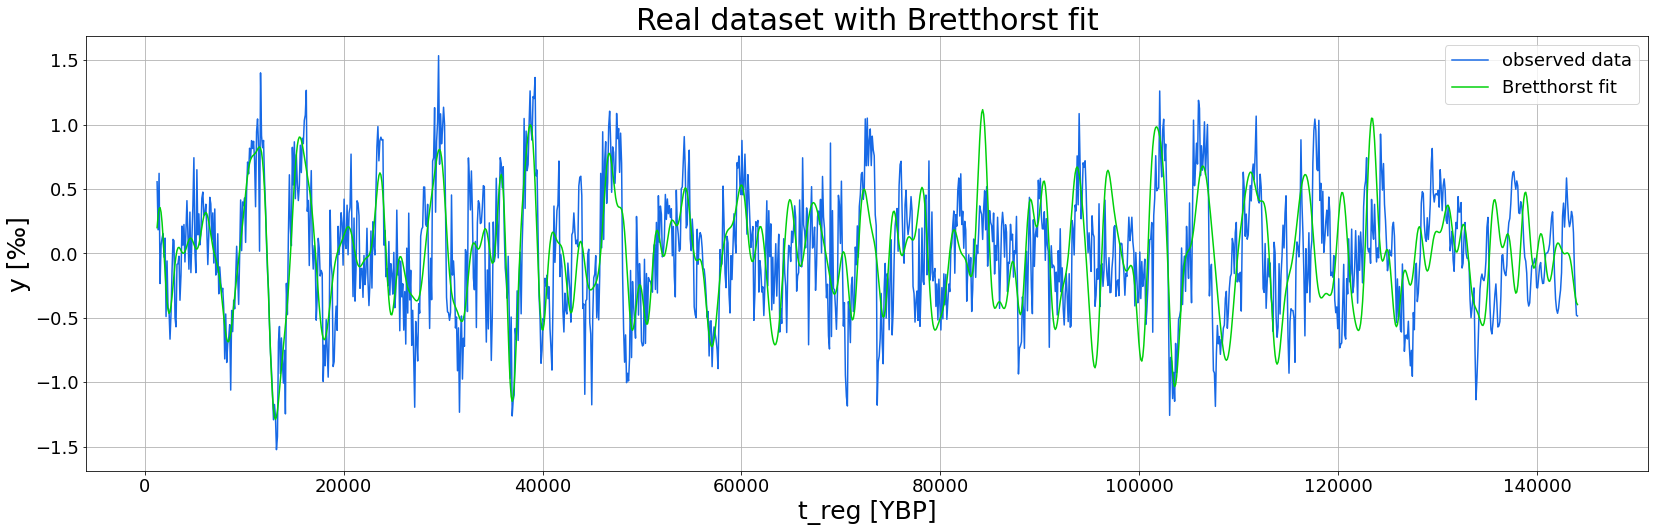

In [10]:
# plot Bretthorst fit
plot_fit(df, fit_bret, 0, n, 'Bretthorst fit')

The STAN code for this study is the same as that used previously for the synthetic dataset. The initialization values of the parameters we want to infer are also the same.

In [11]:
# define the program code for stan
code = """
data {

    int<lower=0> n;
    vector[n] y_obs;
    
    int<lower=0> N_cycle_inf;
    vector<lower=0>[N_cycle_inf] freq;

    real<lower=0> dt;

}

parameters {

    ordered[n-1] t;

    real mean;
    real<lower=0> sd;
    real<lower=50> tau;

    real<lower=0> sigma_y;

    vector<lower=0>[N_cycle_inf] A;
    vector<lower=0, upper=2*pi()>[N_cycle_inf] ph;
    
}

transformed parameters {

    //declare xi
    vector[n-1] xi;
        
    //define xi
    xi[1] = t[1]-1250;  
    for(i in 2:n-1) {
        xi[i] = t[i]-t[i-1];  
    }

}

model {

    //priors
    mean ~ normal(100, 1);
    sd ~ gamma(1, 1);   
    tau ~ gamma(25, 0.025);
    sigma_y ~ gamma(2, 10);

    vector[n] mean_y;

    mean_y[1] = 0;
    for(i in 1:N_cycle_inf) {
        mean_y[1] += A[i]*cos(2*pi()*freq[i]*1250+ph[i]);
    }
    y_obs[1] ~ normal(mean_y[1], sigma_y);

    for(i in 2:n) {
        mean_y[i] = 0;
        for(j in 1:N_cycle_inf) {
            mean_y[i] += A[j]*cos(2*pi()*freq[j]*t[i-1]+ph[j]);
        }
        y_obs[i] ~ normal(mean_y[i], sigma_y);
    }
 
    xi[1] ~ normal(mean, sd*sqrt(2*(dt/tau)));
    
    for (i in 2:n-1) {
      xi[i] ~ normal(mean*(dt/tau)+(1-(dt/tau))*xi[i-1], sd*sqrt(2*(dt/tau)));
    }

}
"""

In [12]:
# number of cycles to be inferred
N_cycle_inf = 29

# assign the data to the dictionary
data = {'n':n, 'y_obs':df['y_obs'].values,
        'N_cycle_inf':N_cycle_inf, 'freq':freq[:N_cycle_inf], 'dt':100}

# build the model
#posterior = stan.build(code, data=data, random_seed=12345)

In [13]:
# sample from the model
n_chains = 4
n_warmup = 2000
n_sample = 4000

'''fit = posterior.sample(num_chains=n_chains, num_samples=n_sample, num_warmup=n_warmup,
                    init=[{'A':df_cycle['A'].values[:N_cycle_inf],
                        'ph':df_cycle['ph'].values[:N_cycle_inf],
                        't':df['t'].values,
                        'mean':100, 'sd':1, 'tau':1000, 'sigma_y':0.2}]*n_chains)'''

"fit = posterior.sample(num_chains=n_chains, num_samples=n_sample, num_warmup=n_warmup,\n                    init=[{'A':df_cycle['A'].values[:N_cycle_inf],\n                        'ph':df_cycle['ph'].values[:N_cycle_inf],\n                        't':df['t'].values,\n                        'mean':100, 'sd':1, 'tau':1000, 'sigma_y':0.2}]*n_chains)"

In [14]:
#df_inf = fit.to_frame()
#df_inf.to_csv('case_study.csv', index=True)

# Results

In [15]:
# load dataframe
path_name = 'run_case.csv'
df_inf = pd.read_csv(path_name)

In [16]:
# flattening
flattening = n_chains
df_inf = df_inf.groupby(np.arange(len(df_inf))//flattening).median()

# thinnng
thinning = 1
df_inf = df_inf.iloc[np.arange(0, n_sample*(n_chains - flattening + 1), thinning)]

In [17]:
# compute the estimator of each parameter as the median of the samples
def infer_parameter(keys, df):

    param_inf = {}

    for key in keys:
        if key == 't.0':
            param_inf[key] = list(param_t.values())[0]
        else:
            # inferred parameters
            param_inf[key] = np.median(df[key])
    
    return param_inf

In [18]:
# auto-regressive inferred parameters
param_AR_inf = infer_parameter(['mean', 'sd', 'tau'], df_inf)

# sigma_y inferred parameter
param_sigma_y_inf = infer_parameter(['sigma_y'], df_inf)

# A inferred parameters
param_A_inf = infer_parameter(list(param_A.keys())[:N_cycle_inf], df_inf)

# ph inferred parameters
param_ph_inf = infer_parameter(list(param_ph.keys())[:N_cycle_inf], df_inf)

# t inferred parameters
param_t_inf = infer_parameter(list(param_t.keys()), df_inf)

# concatenate dictionaries
param_inf = {**param_AR_inf, **param_sigma_y_inf, **param_A_inf, **param_ph_inf}

The inferred values of the parameters $\mu$, $\sigma$, $\tau$ and $\sigma_y$ are here printed.

In [19]:
# print inferred parameters
for key in list({**param_AR_inf, **param_sigma_y_inf}.keys()):
    
    print(key)

    prec = None
    if key in ['mean']:
        prec = 1
    elif key in ['sd']:
        prec = 0
    elif key in ['tau']:
        prec = 0
    elif key in ['sigma_y']:
        prec = 3

    print('inf:', round(param_inf[key], prec),
          '+-', round(np.sqrt(np.var(df_inf[key])), prec))

mean
inf: 100.0 +- 0.5
sd
inf: 34.0 +- 1.0
tau
inf: 834.0 +- 60.0
sigma_y
inf: 0.272 +- 0.003


The inferred values of all the $A$ and $\phi$ parameters are here printed.

In [20]:
# print Bretthorst and inferred parameters
for key in list({**param_A_inf, **param_ph_inf}.keys()):
    print(key)
    print('Bretthorst:', round(param[key], 2),
          'inf:', round(param_inf[key], 2),
          '+-', round(np.sqrt(np.var(df_inf[key])), 2))

A.1
Bretthorst: 0.18 inf: 0.06 +- 0.01
A.2
Bretthorst: 0.17 inf: 0.2 +- 0.01
A.3
Bretthorst: 0.15 inf: 0.16 +- 0.01
A.4
Bretthorst: 0.15 inf: 0.14 +- 0.01
A.5
Bretthorst: 0.13 inf: 0.08 +- 0.01
A.6
Bretthorst: 0.13 inf: 0.1 +- 0.01
A.7
Bretthorst: 0.12 inf: 0.08 +- 0.01
A.8
Bretthorst: 0.11 inf: 0.16 +- 0.01
A.9
Bretthorst: 0.11 inf: 0.09 +- 0.01
A.10
Bretthorst: 0.11 inf: 0.03 +- 0.01
A.11
Bretthorst: 0.11 inf: 0.09 +- 0.01
A.12
Bretthorst: 0.1 inf: 0.17 +- 0.01
A.13
Bretthorst: 0.1 inf: 0.16 +- 0.01
A.14
Bretthorst: 0.1 inf: 0.11 +- 0.01
A.15
Bretthorst: 0.09 inf: 0.11 +- 0.01
A.16
Bretthorst: 0.09 inf: 0.04 +- 0.01
A.17
Bretthorst: 0.09 inf: 0.07 +- 0.01
A.18
Bretthorst: 0.09 inf: 0.04 +- 0.01
A.19
Bretthorst: 0.09 inf: 0.05 +- 0.01
A.20
Bretthorst: 0.08 inf: 0.07 +- 0.01
A.21
Bretthorst: 0.08 inf: 0.13 +- 0.01
A.22
Bretthorst: 0.07 inf: 0.01 +- 0.01
A.23
Bretthorst: 0.07 inf: 0.02 +- 0.01
A.24
Bretthorst: 0.07 inf: 0.07 +- 0.01
A.25
Bretthorst: 0.07 inf: 0.08 +- 0.01
A.26
Bretthors

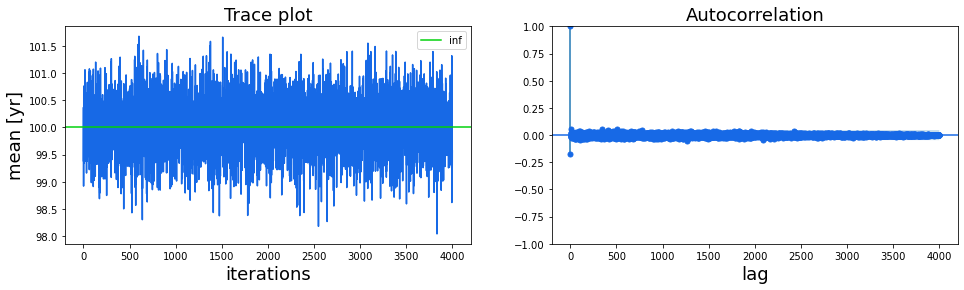

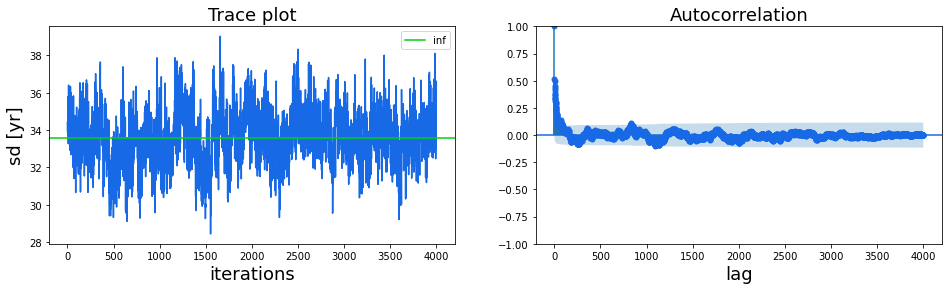

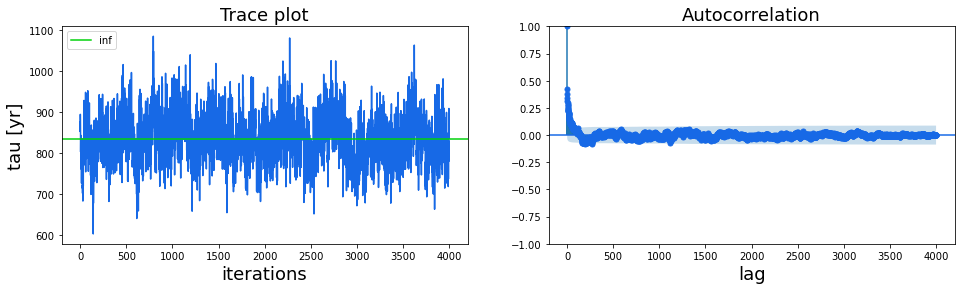

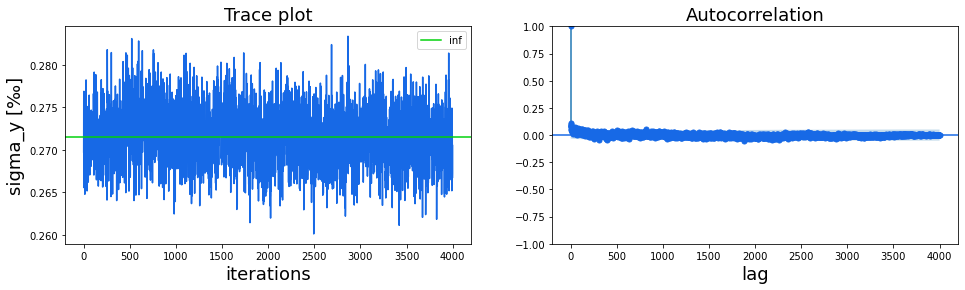

In [21]:
def plot_mc_acf(df, key):

    # plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

    # markov chain
    ax[0].plot(np.arange(0, df.shape[0]), df[key].values, color=col_blue)
    ax[0].axhline(y=np.median(df[key]), color=col_green, label='inf')
    ax[0].set_xlabel('iterations')
    if key == 'sigma_y':
        ax[0].set_ylabel(key + ' [‰]')
    else :
        ax[0].set_ylabel(key + ' [yr]')
    ax[0].set_title('Trace plot')
    ax[0].tick_params(axis='x', labelsize=10)
    ax[0].tick_params(axis='y', labelsize=10)
    ax[0].legend()

    # autocorrelation
    plot_acf(df[key], ax=ax[1], lags = int(np.floor(n_sample))-1, color=col_blue)
    ax[1].set_xlabel('lag')
    ax[1].tick_params(axis='x', labelsize=10)
    ax[1].tick_params(axis='y', labelsize=10)

    plt.show()


for key in list({**param_AR_inf, **param_sigma_y_inf}.keys()):
    plot_mc_acf(df_inf, key)

In [22]:
# plot pairwise scatter plot matrix, histograms and correlation coefficients
def scatterplot_matrix(param_inf, n, df):

    # auto-regressive and sigma_y
    key = list(param_inf.keys())[:4]
    # A
    key = key + ['A.'+str(i+1) for i in range(0, n)]
    # ph
    key = key + ['ph.'+str(i+1) for i in range(0, n)]

    # plot
    fig, ax = plt.subplots(nrows=len(key), ncols=len(key), figsize=(len(key)*2, len(key)*2))

    # rows
    for i in range(0,len(key)):

        # columns
        for j in range(0,len(key)):

            # histograms
            if j == i:
                ax[i,i].hist(df[key[i]], bins=25, color=col_blue)
                ax[i,i].axvline(x=param_inf[key[i]], color=col_green, linestyle='--', label='inf '+key[i])
                ax[i,i].set_title(key[i])
                ax[i,i].grid()

            # scatter plots
            elif j < i:
                ax[i,j].scatter(df[key[j]], df[key[i]], color=col_blue, alpha=0.5)
                ax[i,j].grid()

            # correlation coefficients
            else:
                rho = np.corrcoef(df[key[i]], df[key[j]])[0,1]
                ax[i,j].text(0.5, 0.5, str(np.round(rho, 2)), ha = 'center', va = 'center')
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].yaxis.set_ticklabels([])

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
                        
    plt.show()

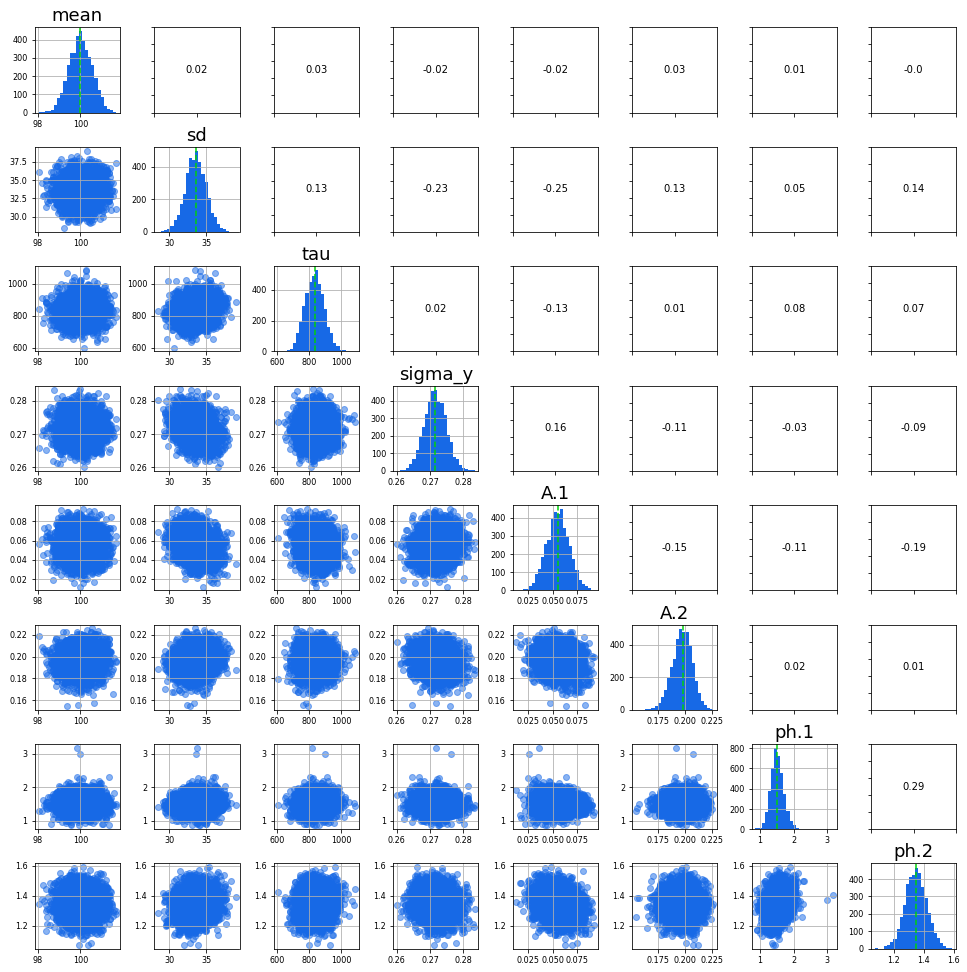

In [23]:
# pairwise scatter plot matrix, histograms (marginals) and correlation coefficients
scatterplot_matrix(param_inf, 2, df_inf)

In [24]:
# plot inferred autoregressive model
def infer_AR(n, df):
        
    # xi inferred parameters and 95% credible interval
    xi_inf = {}
    xi_inf_95CI = {}
    for key in ['xi.'+str(i) for i in range(0, n)]:
        if key == 'xi.0':
            xi_inf[key] = 100
            xi_inf_95CI[key] = [100, 100]
        else:
            xi_inf[key] = np.median(df[key])
            xi_inf_95CI[key] = np.quantile((df[key]), [0.025, 0.975])
            
    low = [x[0] for x in list(xi_inf_95CI.values())]
    high = [x[1] for x in list(xi_inf_95CI.values())]

    fig, ax = plt.subplots(figsize=(24,8))
    ax.vlines(x=1250 + np.arange(0, n*100, 100), ymin=low, ymax=high, color=col_grey, alpha=0.3, label='95% CI')
    ax.plot(1250 + np.arange(0, n*100, 100), list(xi_inf.values()), color=col_green, label='inference', lw=1.5)
    ax.axhline(y=100, color='k', linestyle='--')
    ax.set_xlabel('t_reg [YBP]', fontsize=23)
    ax.set_ylabel(r'$\xi$ [yr]', fontsize=23)
    ax.set_title('Inferred auto-regressive process', fontsize=27)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid()
    ax.legend(fontsize=16)
    plt.show()

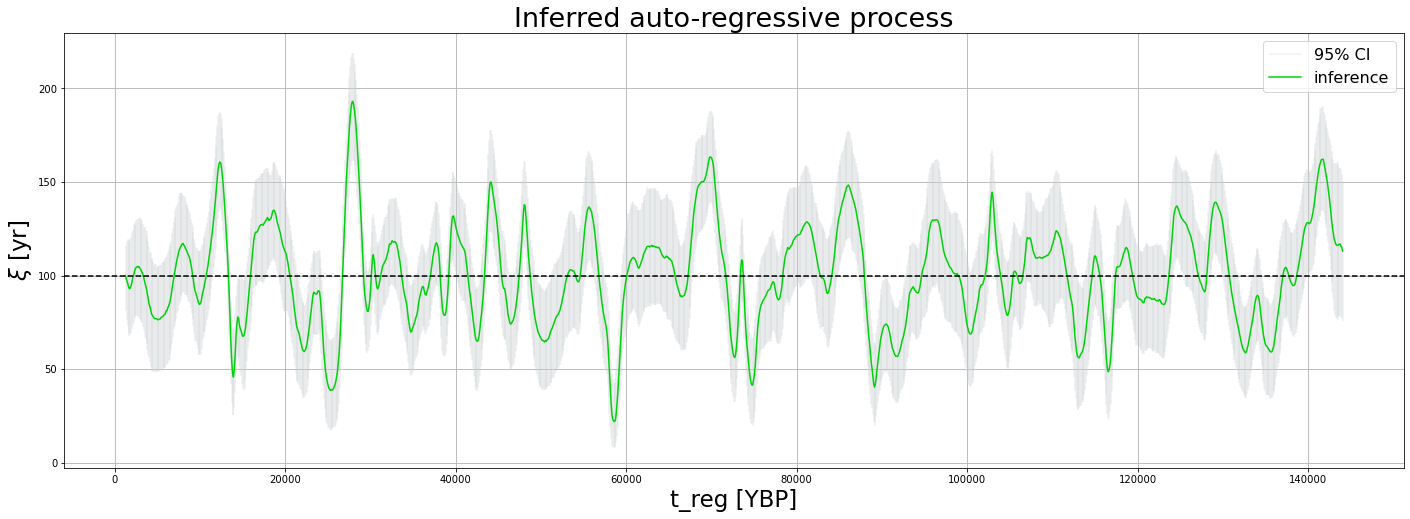

In [25]:
# plot inferred autoregressive model
infer_AR(n, df_inf)

In [26]:
# plot trace (Markov chain) and histogram (marginal) of a t inferred parameter
def traceplot(param_t, param_t_inf, i, df):

    key = 't.'+str(i)

    # plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    ax[0].plot(np.arange(0, df.shape[0]), df[key], color=col_blue)
    ax[0].axhline(y = param_t[key], color='k', linestyle='--', label='reg '+key)
    ax[0].axhline(y = param_t_inf[key], color=col_green, linestyle='--', label='inf '+key)
    ax[0].set_xlabel('iterations')
    ax[0].set_ylabel(key + ' [yr]')
    ax[0].set_title('Trace plot')
    ax[0].tick_params(axis='x', labelsize=10)
    ax[0].tick_params(axis='y', labelsize=10)
    ax[0].legend()
    ax[0].grid()

    ax[1].hist(df[key], bins=25, color=col_blue)
    ax[1].axvline(x = param_t[key], color='k', linestyle='--', label='reg '+key)
    ax[1].axvline(x = param_t_inf[key], color=col_green, linestyle='--', label='inf '+key)
    ax[1].set_xlabel(key + ' [yr]')
    ax[1].set_title('Marginalized posterior histogram')
    ax[1].tick_params(axis='x', labelsize=10)
    ax[1].tick_params(axis='y', labelsize=10)
    ax[1].legend()
    ax[1].grid()

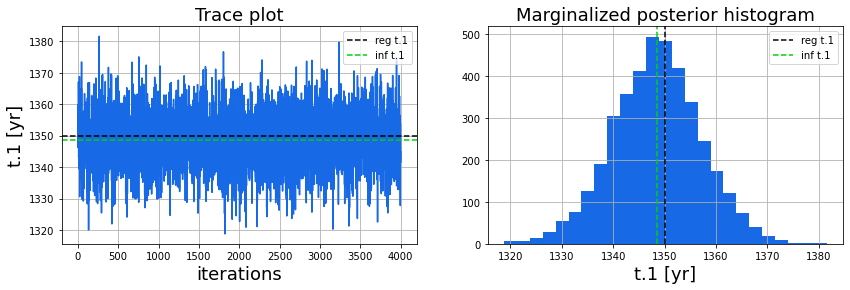

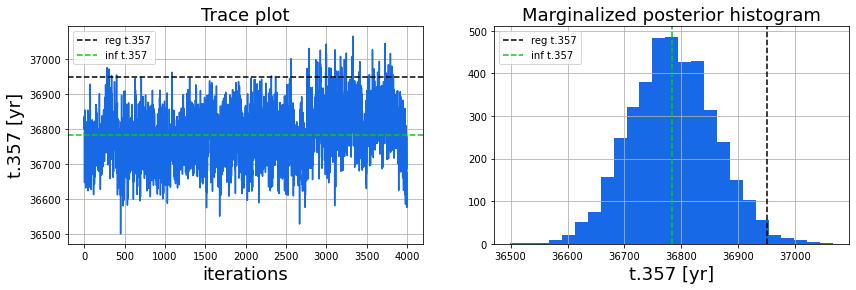

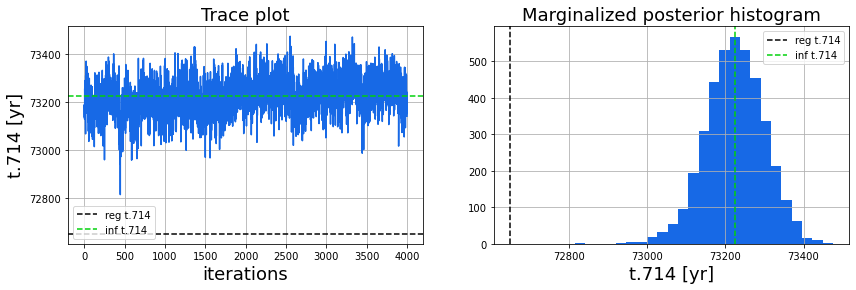

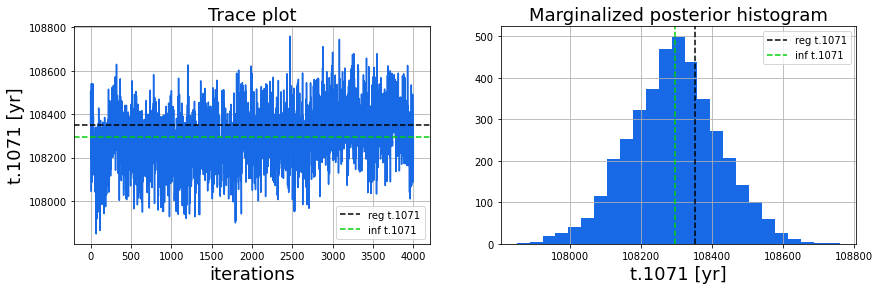

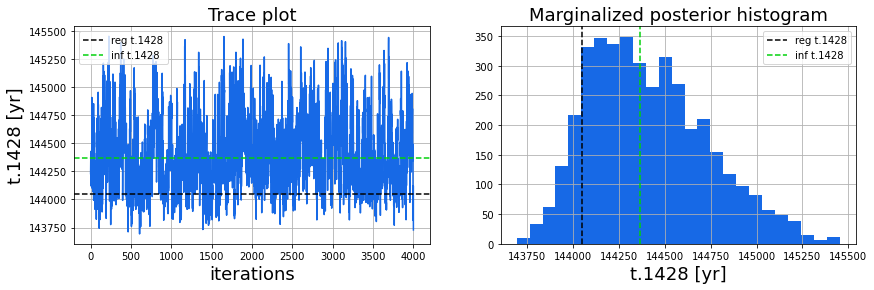

In [27]:
# plot trace (Markov chain) and histogram (marginal) of a t inferred parameter
ts = [1, 0.25*n, 0.5*n, 0.75*n, n-1]
for i in ts:
    traceplot(param_t, param_t_inf, int(i), df_inf)

In [28]:
# 95% credible interval of t inferred parameters
param_t_inf_95CI = param_t_inf.copy()
for key in list(param_t_inf.keys()):
    if key == 't.0':
        param_t_inf_95CI[key] = [1250, 1250]
    else:
        param_t_inf_95CI[key] = np.quantile((df_inf[key]), [0.025, 0.975])

In [29]:
# plot credible interval of all t inferred parameters
def credible_interval(param_t, param_t_inf, param_t_inf_95CI):

    # define t_reg
    t_reg = np.array(list(param_t.values()))
    
    # shifted inferred value
    y_inf = np.array(list(param_t_inf.values())) - t_reg
    # 95% credible interval
    low = [x[0] for x in list(param_t_inf_95CI.values())] - t_reg
    high = [x[1] for x in list(param_t_inf_95CI.values())] - t_reg

    # plot
    fig, ax = plt.subplots(figsize=(24, 8))

    ax.vlines(x=np.arange(0, len(y_inf)), ymin=low, ymax=high, color=col_grey, alpha=0.3, label='95% CI')
    ax.plot(np.arange(0, len(y_inf)), y_inf, color=col_green, label='inference', lw=1.5)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_xlabel('index', fontsize=23)
    ax.set_ylabel(r'$\Delta$t [yr]', fontsize=23)
    ax.set_title('Difference between the inferred and regular time-scale', fontsize=27)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=16)
    ax.grid()
    plt.show()

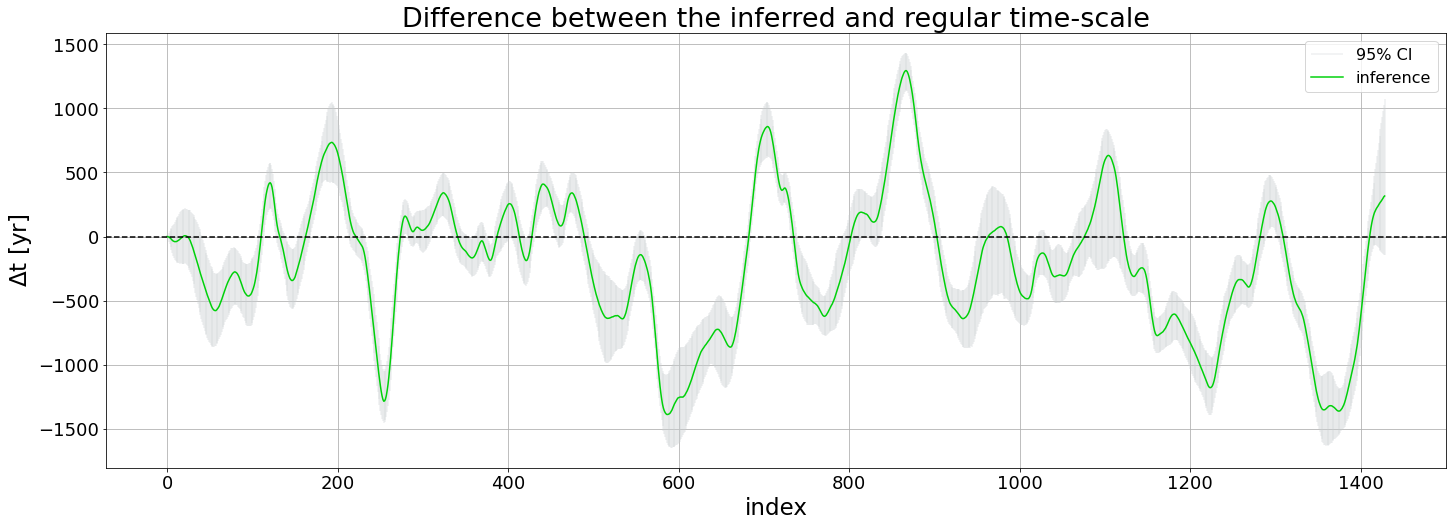

In [30]:
credible_interval(param_t, param_t_inf, param_t_inf_95CI)

In [31]:
# compute inferred fit
fit_corr = fit_data(param_A_inf, param_ph_inf, param_t_inf, freq, N_cycle_inf, n)

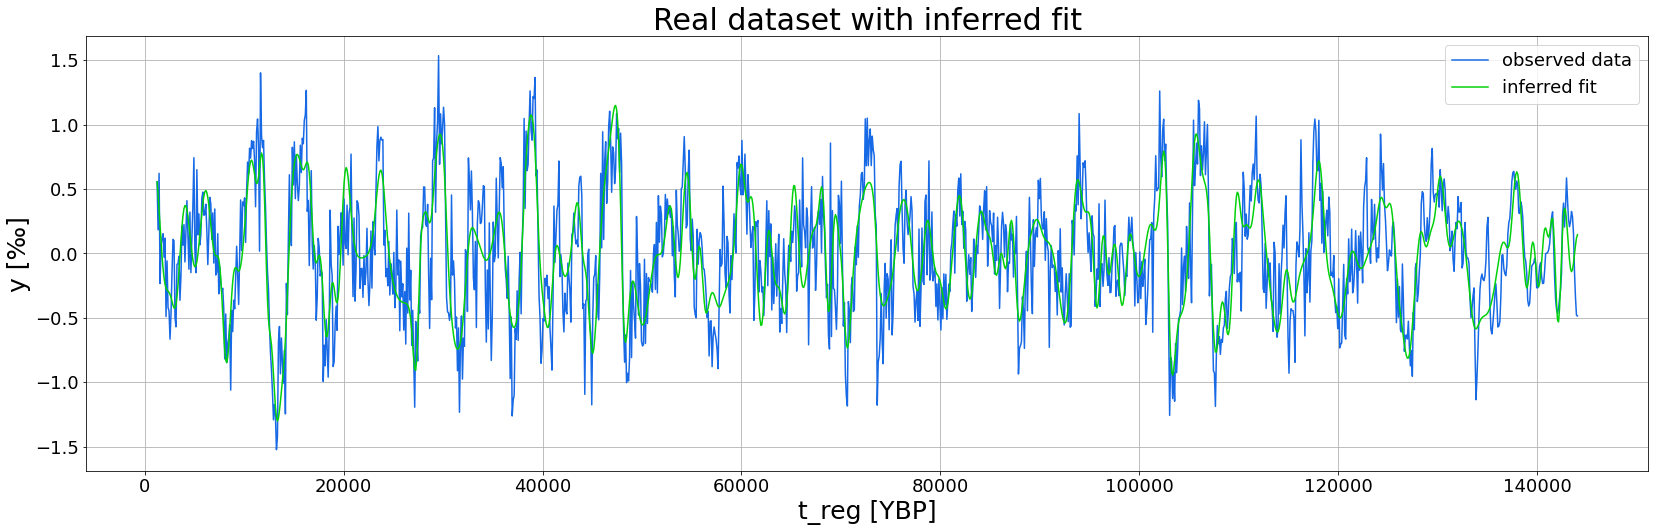

In [32]:
# plot inferred fit
plot_fit(df, fit_corr, 0, n, 'inferred fit')

Finally, to evaluate the results of inference, the following sums of squared residuals are reported:

$$
ssr_{Bret} = \sum_{i=1}^{n}(y_{obs,i}-y_{Bret,i})^2
$$

$$
ssr_{inf} = \sum_{i=1}^{n}(y_{obs,i}-y_{inf,i})^2
$$

In [33]:
# sum of squared residuals
ssr = np.sum((df['y_obs'] - fit_bret)**2)
ssr_corr = np.sum((df['y_obs'] - fit_corr)**2)

print('ssr of Bretthorst method:', round(ssr,2))
print('ssr of Bayesian inference with time-scale correction:', round(ssr_corr, 2))

ssr of Bretthorst method: 233.59
ssr of Bayesian inference with time-scale correction: 127.78


In [34]:
def plot_inference(df, param_t_inf, start, end):

    df = df[start:end]
    t_inf = list(param_t_inf.values())[start:end]

    # plot
    fig, ax = plt.subplots(figsize=(24,8))

    ax.plot(df['t'], df['y_obs'], color=col_blue, label='observed data')
    ax.plot(t_inf, df['y_obs'], color=col_green, label='corrected data')
    ax.set_xlabel('t [YBP]', fontsize=23)
    ax.set_ylabel('y [‰]', fontsize=23)
    ax.set_ylim(max(abs(df['y_obs']))*np.array([-1.1, 1.1]))
    ax.set_title('Time-scale correction', fontsize=27)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=16)
    plt.grid()
    plt.show()

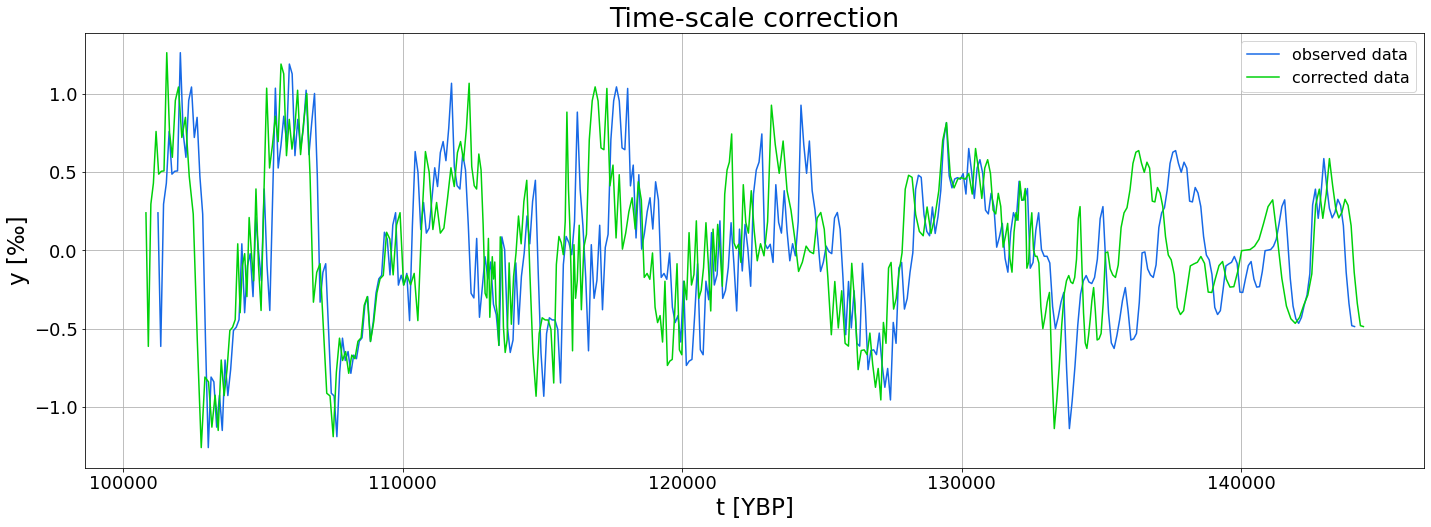

In [35]:
plot_inference(df, param_t_inf, 1000, n)

# STAN vs Timedeppar

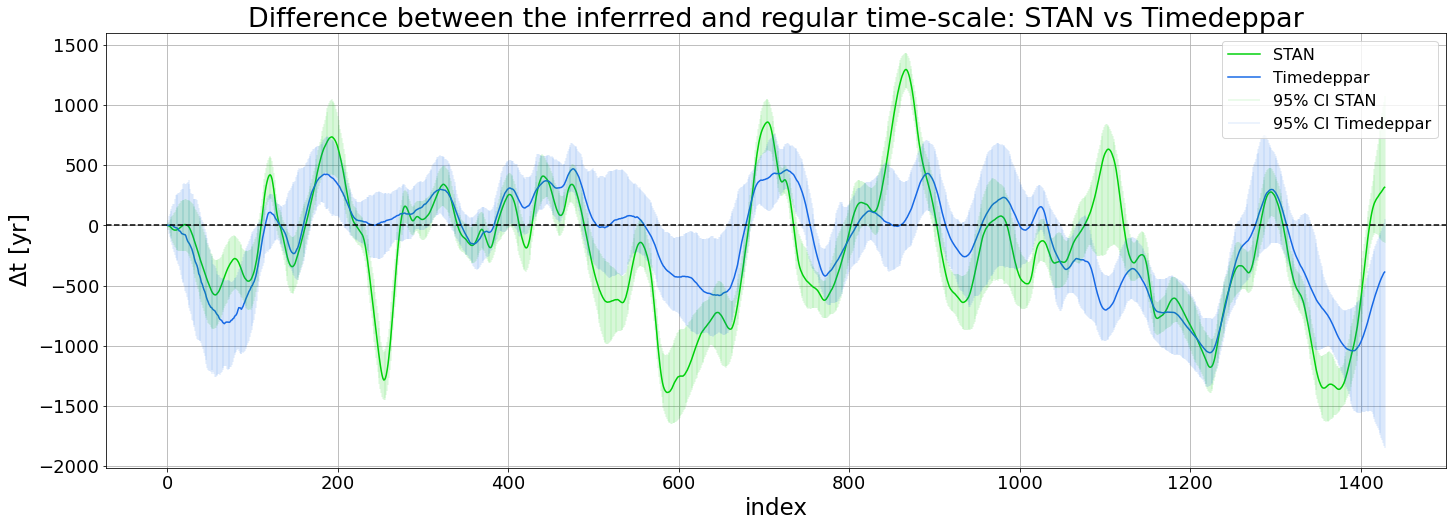

In [38]:
def magic(param_t, param_t_inf, param_t_inf_95CI, df_delta_t_TD):

    # define t_reg
    t_reg = np.array(list(param_t.values()))

    # shifted inferred value
    y_inf = np.array(list(param_t_inf.values())) - t_reg
    # 95% credible interval
    low = [x[0] for x in list(param_t_inf_95CI.values())] - t_reg
    high = [x[1] for x in list(param_t_inf_95CI.values())] - t_reg

    # plot
    fig, ax = plt.subplots(figsize=(24, 8))

    ax.plot(np.arange(0, len(y_inf)), y_inf, color=col_green, label='STAN')
    ax.plot(np.arange(0, len(y_inf)), df_delta_t_TD.iloc[:,0], color=col_blue, label='Timedeppar')
    ax.vlines(x=np.arange(0, len(y_inf)), ymin=low, ymax=high, color=col_green, alpha=0.1, label='95% CI STAN')
    ax.vlines(x=np.arange(0, len(y_inf)), ymin=df_delta_t_TD['low'], ymax=df_delta_t_TD['high'], color=col_blue, alpha=0.1, label='95% CI Timedeppar')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_xlabel('index', fontsize=23)
    ax.set_ylabel(r'$\Delta$t [yr]', fontsize=23)
    ax.set_title('Difference between the inferrred and regular time-scale: STAN vs Timedeppar', fontsize=27)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=16)
    ax.grid()

df_delta_t_TD = pd.read_csv('delta_t_TD.txt')
magic(param_t, param_t_inf, param_t_inf_95CI, df_delta_t_TD)

As we mentioned, the scope of this project is very difficult, since we are applying Bayesian inference to a high-dimensional problem. To understand the reliability of the algorithm we have developed for the real case, we can compare the results obtained with STAN and Timedeppar. The most significant result is that they follow the same trend. STAN seems to be less conservative in some areas where it tends to oscillate a lot, but then quickly returns close to the Timedeppar line. Timedeppar seems to be more stable as in the synthetic study where it achieved an impressive result. We can therefore conclude that this is a promising approach to correct the time scale in $\delta^{18}O$ records. This algorithm can be further developed in many aspects, for example, it should be possible to set more informative priors by understanding more deeply the time series we are analyzing from the perspective of paloclimatology. However, we can say that these are already promising results.